<a href="https://colab.research.google.com/github/IsinghGitHub/CellStrat/blob/master/Redda_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression on HR Performance Data

# 1 | Library Import and Data Loading

In [1111]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import metrics

## Data Cleaning & Preparation

In [1112]:
""" Load in the data and examine the head. """

data = '/content/drive/MyDrive/Redda/AI Model Data v140823 CellStrat_V1.xlsx'
df = pd.read_excel(data)
df.head(5)

,ID,COMPANY ID,JOB,Department,MBTI,Predictor 1,Predictor 2,Predictor 3,Predictor 4,CTAR,Aggregate total using predictors weights of study 2,Decision based on Study 2,Individual Performance FY22,Gender,Age,Tenure,Degree
0,ABS025,ABS,Sales,Sales,ISTJ,0.510,1.00,0.08,0.33,0.00,0.662237,Hired,0.7,F,35.0,12.0,Engineer in Optic
1,ABS026,ABS,Consultant,Sales,ESTJ,0.630,0.70,0.25,0.33,0.08,0.550900,Hired,0.7,M,42.0,16.0,Telecommucation Engineer
2,ABS027,ABS,Chief Financial Officer,Finance,ESTP,0.785,0.57,0.17,0.08,-0.17,0.448472,Hired,0.7,M,40.0,12.0,Bachelor in accounting
3,ABS028,ABS,Project Manager,Sales,ISTJ,0.650,0.43,0.17,0.42,-0.17,0.413302,Hired,0.7,F,42.0,15.0,Engineer in computer science
4,ABS029,ABS,Consultant,Sales,ISTJ,0.755,0.30,0.08,0.42,-0.08,0.343929,Not Hired,0.7,M,37.0,10.0,Engineer in computer science


# 2 | Data preprocessing

In [1113]:
df.columns


Index(['ID', 'COMPANY ID', 'JOB', 'Department', 'MBTI', 'Predictor 1',
       'Predictor 2', 'Predictor 3', 'Predictor 4', 'CTAR',
       'Aggregate total using predictors weights of study 2',
       'Decision based on Study 2', 'Individual Performance FY22', 'Gender',
       'Age', 'Tenure', 'Degree'],
      dtype='object')

 ### 2.1 Rename columns

In [1114]:

# Rename columns
new_column_names = {
    'Decision based on Study 2': 'Decisionstd2',
    'Individual Performance FY22': 'IndividualPerf',
    'Aggregate total using predictors weights of study 2': 'AggregateTotPred',
    'Predictor 1':'Predictor1',
    'Predictor 2':'Predictor2',
    'Predictor 3':'Predictor3',
    'Predictor 4':'Predictor4'
    # Add more mappings as needed
}

df.rename(columns=new_column_names, inplace=True)

In [1115]:
""" Iterate through the dataframes columns and covert to lowercase for QoL. """
low_col = []
for i in df.columns:
    i = i.lower()
    low_col.append(i)
df.columns = low_col

In [1116]:
# Count null values in each column
null_counts = df.isnull().sum()

print(null_counts)

id                  5
company id          5
job                 5
department          5
mbti                6
predictor1          5
predictor2          5
predictor3          5
predictor4          5
ctar                5
aggregatetotpred    5
decisionstd2        5
individualperf      6
gender              5
age                 3
tenure              2
degree              5
dtype: int64


In [1117]:
# Calculate null percentages for each column
null_percentages = (df.isnull().sum() / len(df)) * 100

# Print null percentages
print("Null Percentages in Each Column:")
print(null_percentages)

Null Percentages in Each Column:
id                  1.424501
company id          1.424501
job                 1.424501
department          1.424501
mbti                1.709402
predictor1          1.424501
predictor2          1.424501
predictor3          1.424501
predictor4          1.424501
ctar                1.424501
aggregatetotpred    1.424501
decisionstd2        1.424501
individualperf      1.709402
gender              1.424501
age                 0.854701
tenure              0.569801
degree              1.424501
dtype: float64


In [1118]:
df.shape


(351, 17)

In [1119]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                346 non-null    object 
 1   company id        346 non-null    object 
 2   job               346 non-null    object 
 3   department        346 non-null    object 
 4   mbti              345 non-null    object 
 5   predictor1        346 non-null    float64
 6   predictor2        346 non-null    float64
 7   predictor3        346 non-null    float64
 8   predictor4        346 non-null    float64
 9   ctar              346 non-null    float64
 10  aggregatetotpred  346 non-null    float64
 11  decisionstd2      346 non-null    object 
 12  individualperf    345 non-null    float64
 13  gender            346 non-null    object 
 14  age               348 non-null    float64
 15  tenure            349 non-null    float64
 16  degree            346 non-null    object 
dt

In [1120]:
""" Transpose the describe to make it easier to read. """
df.describe().T

,count,mean,std,min,25%,50%,75%,max
predictor1,346.0,0.603829,0.122015,0.000000,0.531250,0.612500,0.685000,0.950000
predictor2,346.0,0.200202,0.295849,-0.670000,0.007500,0.230000,0.400000,1.000000
predictor3,346.0,-0.046618,0.229811,-0.830000,-0.170000,0.000000,0.080000,0.670000
predictor4,346.0,0.054942,0.256957,-0.580000,-0.080000,0.080000,0.250000,0.920000
ctar,346.0,-0.103439,0.234355,-0.750000,-0.250000,-0.080000,0.080000,0.500000
aggregatetotpred,346.0,0.188326,0.207069,-0.493765,0.054516,0.204447,0.325846,0.682633
individualperf,345.0,0.590203,0.180067,0.050000,0.500000,0.600000,0.700000,1.630000
age,348.0,33.081816,7.974502,7.521148,28.000000,32.000000,37.000000,57.082192
tenure,349.0,3.407330,5.464968,0.000000,0.000000,0.500000,5.086111,29.000000


In [1121]:
""" Investigate categorical columns that seem irrelevent. """
df.department.value_counts()

Sales                             112
IT                                 93
Finance                            52
Supply Chain                       34
After Sales                        10
Marketing                          10
General Management                  9
Technical                           7
Payroll                             4
Sales/IT                            4
Sales/Marketing                     3
Factory                             3
Sales/Finance                       2
Human Ressources                    1
Sales SPECIALIST CYBERSECURITE      1
Sales Director                      1
Name: department, dtype: int64

In [1122]:
""" Investigate categorical columns that seem irrelevent. """

df.degree.value_counts()

Associate degree in accounting                 24
Engineer in computer science                   19
High School Graduation                         16
Bachelor in accounting                         15
Associate degree in management                 15
                                               ..
Bachelor in computer application                1
Bachelor in software                            1
Associate degree in business administration     1
Associate degree in law                         1
Engineer                                        1
Name: degree, Length: 105, dtype: int64

In [1123]:
""" Investigate categorical columns that seem irrelevent. """

df.mbti.value_counts()

ISTJ    105
ESTJ    105
ENTJ     34
INTJ     29
ESFJ     21
ISTP      9
ISFJ      8
ESTP      7
ESFP      7
ENFJ      6
ENTP      4
INFJ      3
INTP      3
ISFP      2
ENFP      1
INFP      1
Name: mbti, dtype: int64

In [1124]:
df.columns


Index(['id', 'company id', 'job', 'department', 'mbti', 'predictor1',
       'predictor2', 'predictor3', 'predictor4', 'ctar', 'aggregatetotpred',
       'decisionstd2', 'individualperf', 'gender', 'age', 'tenure', 'degree'],
      dtype='object')

## 2.2 Dealing with duplicated values

In [1125]:
print('Number of duplicated values in training dataset: ', df.duplicated().sum())


Number of duplicated values in training dataset:  1


In [1126]:
df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")
print("*" * 100)


Duplicated values dropped succesfully
****************************************************************************************************


## Creating numerical and categorical lists

In [1127]:
# distinction is based on the number of different values in the column
columns = list(df.columns)

categoric_columns = []
numeric_columns = []

for i in columns:
    if len(df[i].unique()) > 6:
        numeric_columns.append(i)
    else:
        categoric_columns.append(i)

categoric_columns = categoric_columns[:-1] # Excluding target:'Churn'

In [1128]:
print('Numerical fetures: ',numeric_columns)
print('Categorical fetures: ',categoric_columns)

Numerical fetures:  ['id', 'company id', 'job', 'department', 'mbti', 'predictor1', 'predictor2', 'predictor3', 'predictor4', 'ctar', 'aggregatetotpred', 'individualperf', 'age', 'tenure', 'degree']
Categorical fetures:  ['decisionstd2']


### We will be dropping the above columns along with some not required columns

In [1129]:
columns_to_drop = ["job","company id","department","degree","aggregatetotpred"]
df = df.drop(columns=columns_to_drop)

In [1130]:
df.head()

,id,mbti,predictor1,predictor2,predictor3,predictor4,ctar,decisionstd2,individualperf,gender,age,tenure
0,ABS025,ISTJ,0.510,1.00,0.08,0.33,0.00,Hired,0.7,F,35.0,12.0
1,ABS026,ESTJ,0.630,0.70,0.25,0.33,0.08,Hired,0.7,M,42.0,16.0
2,ABS027,ESTP,0.785,0.57,0.17,0.08,-0.17,Hired,0.7,M,40.0,12.0
3,ABS028,ISTJ,0.650,0.43,0.17,0.42,-0.17,Hired,0.7,F,42.0,15.0
4,ABS029,ISTJ,0.755,0.30,0.08,0.42,-0.08,Not Hired,0.7,M,37.0,10.0


In [1131]:
""" Apply Pandas get_dummies function to the dataframe to transform the categorical variables to numeric.
    This will create additional columns in your dataframe."""

#df_dum = pd.get_dummies(df)

' Apply Pandas get_dummies function to the dataframe to transform the categorical variables to numeric.\n    This will create additional columns in your dataframe.'

In [1132]:
#df_dum

In [1133]:
#df_dum

## Correlation

Find out which attribute correlates with individualperf the most.



### What are the types of the variables?

Basically we have two types of variables if we are only looking into the variable itself. We have continuous variable and categorical variable. While continuous variables can be further categorize as either interval or ratio variables, categorical variables can be further categorize as either nominal, ordinal or dichotomous.

'decisionstd2' is a dichotomous variable as it has two categories, 'Hired' and 'NotHired'.

'MBTI' is a nominal variable as it has more than two categories. ISTJ, 'ESTP', 'ESTJ.



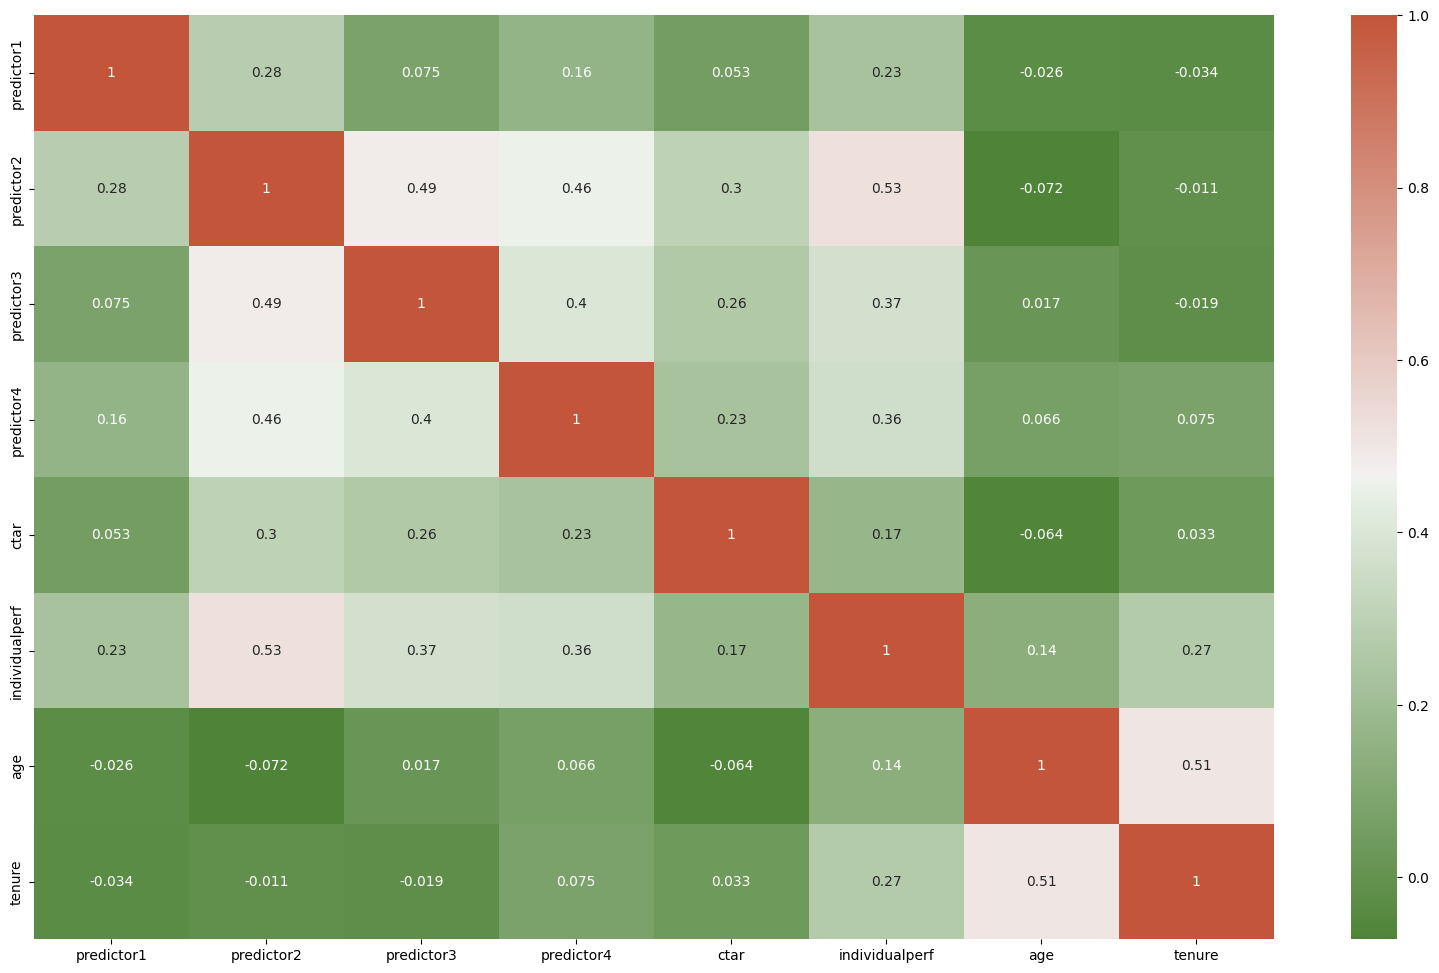

In [1134]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#df_cor = df_l.iloc[:,5:]
df_cor = df
corrmat = df_cor.corr()

plt.figure(figsize=(20, 12))
p =sns.heatmap(corrmat, annot=True, cmap=sns.diverging_palette(120, 20, as_cmap=True))

The number in each box represents the Pearson Correlation Coefficient between the two variables.

The math behind this: It's the covariance of the two variables divided by the standard deviation of the two variables. In this method, the correlation ranges from -1 to 1, which allows us to tell how strong the relationship it is between the two variables as the bigger the absolute it is the more correlated they are, while we can't tell it from covariance. That's why the first box is 1 as 'score' is 100% correlated with 'score' itself.



Back to our questions, regarding the correlation coefficient, we can see that 'predictor2','predictor3' and 'predictor4' have the biggest positive number, 0.53,0.37, and 0.36, while 'age' is the most negative one, -0.072.

We can easily interpret it as the following: The bigger number of 'predictor' the bigger  the  'individual_performance' we find and vice versa, 'predictor' is having the most positive relationship with 'individual_performance'.

## Droping unnessesary columns based on the corr results

In [1135]:
columns = ['id', 'company id', 'job', 'department', 'mbti', 'predictor1',
       'predictor2', 'predictor3', 'predictor4', 'ctar', 'aggregatetotpred',
       'decisionstd2', 'individualperf', 'gender', 'age', 'tenure', 'degree']
columns_to_drop = ['id']

In [1136]:
df.columns

Index(['id', 'mbti', 'predictor1', 'predictor2', 'predictor3', 'predictor4',
       'ctar', 'decisionstd2', 'individualperf', 'gender', 'age', 'tenure'],
      dtype='object')

In [1137]:
df = df.drop(columns=columns_to_drop)
df = df.dropna()

In [1138]:
df.columns

Index(['mbti', 'predictor1', 'predictor2', 'predictor3', 'predictor4', 'ctar',
       'decisionstd2', 'individualperf', 'gender', 'age', 'tenure'],
      dtype='object')

## Checking unique values in all the columns

In [1139]:
#Let's check the no. of unique values in all the columns
print('Unique values:')
for i in df.columns:
    print(i,df[i].nunique())
    print()

Unique values:
mbti 16

predictor1 118

predictor2 46

predictor3 18

predictor4 18

ctar 17

decisionstd2 2

individualperf 76

gender 2

age 112

tenure 90



## Let's convert the columns to number

## What is encoding?

Encoding is the technique we use to convert categorical entry in a dataset to a numerical data. Let say we have a dataset of employees in which there is a column that contains the information about the city location of an employee. Now we want to use this data to form a model which could predict the salary of an employee based upon his/her other details. Obviously, this model doesn’t understand anything about the city name. So how will you make the model know about it? For example, an employee who lives in a metropolitan city earns more than employees of a small city. Someway we need to make the model know about this . Yes, the way you are thinking in your mind is what we will do through code. As obvious we are thinking to rank the city based upon some spec . These ways of converting a categorical data to a numerical data are our target.

### One-Hot Encoding


One-Hot Encoding consists on generating a Boolean column for each category for a given qualitative variable.

Limitation of One-Hot Encoding

One-hot encoding is a very popular transformation to the categorical variables. However, it increases the data dimensionality (The Curse of Dimensionality). When the qualitative variables in the dataset have many modalities, the transformation via one-hot encoding will lead to a significant increase in size. This is not desirable especially when the original dataset is already large.

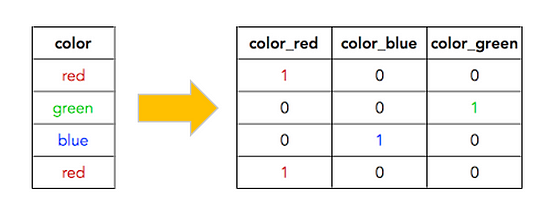Heart Disease

## One hot encoding with Pandas (get_dummies)


In [1140]:
X = df.drop(columns="individualperf" , axis=1)
Y = df["individualperf"]

X["predictor1"].value_counts()

0.675    11
0.620     9
0.595     8
0.525     8
0.575     7
         ..
0.325     1
0.765     1
0.900     1
0.455     1
0.245     1
Name: predictor1, Length: 118, dtype: int64

In [1141]:
X = pd.get_dummies(X, columns=["predictor1"])
X.head()

,mbti,predictor2,predictor3,predictor4,ctar,decisionstd2,gender,age,tenure,predictor1_0.0,...,predictor1_0.785,predictor1_0.79,predictor1_0.7949999999999999,predictor1_0.8049999999999999,predictor1_0.81,predictor1_0.815,predictor1_0.835,predictor1_0.8999999999999999,predictor1_0.9450000000000001,predictor1_0.95
0,ISTJ,1.00,0.08,0.33,0.00,Hired,F,35.0,12.0,0,...,0,0,0,0,0,0,0,0,0,0
1,ESTJ,0.70,0.25,0.33,0.08,Hired,M,42.0,16.0,0,...,0,0,0,0,0,0,0,0,0,0
2,ESTP,0.57,0.17,0.08,-0.17,Hired,M,40.0,12.0,0,...,1,0,0,0,0,0,0,0,0,0
3,ISTJ,0.43,0.17,0.42,-0.17,Hired,F,42.0,15.0,0,...,0,0,0,0,0,0,0,0,0,0
4,ISTJ,0.30,0.08,0.42,-0.08,Not Hired,M,37.0,10.0,0,...,0,0,0,0,0,0,0,0,0,0


In [1142]:
X = pd.get_dummies(X,drop_first=True)
X.head()

,predictor2,predictor3,predictor4,ctar,age,tenure,predictor1_0.0,predictor1_0.245,predictor1_0.25,predictor1_0.28,...,mbti_INFJ,mbti_INFP,mbti_INTJ,mbti_INTP,mbti_ISFJ,mbti_ISFP,mbti_ISTJ,mbti_ISTP,decisionstd2_Not Hired,gender_M
0,1.00,0.08,0.33,0.00,35.0,12.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.70,0.25,0.33,0.08,42.0,16.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.57,0.17,0.08,-0.17,40.0,12.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.43,0.17,0.42,-0.17,42.0,15.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0.30,0.08,0.42,-0.08,37.0,10.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1


In [1143]:
df.columns

Index(['mbti', 'predictor1', 'predictor2', 'predictor3', 'predictor4', 'ctar',
       'decisionstd2', 'individualperf', 'gender', 'age', 'tenure'],
      dtype='object')

In [1144]:
df_dummy = pd.get_dummies(df)

In [1145]:
df_dummy

,predictor1,predictor2,predictor3,predictor4,ctar,individualperf,age,tenure,mbti_ENFJ,mbti_ENFP,...,mbti_INTJ,mbti_INTP,mbti_ISFJ,mbti_ISFP,mbti_ISTJ,mbti_ISTP,decisionstd2_Hired,decisionstd2_Not Hired,gender_F,gender_M
0,0.510,1.00,0.08,0.33,0.00,0.7,35.0,12.0,0,0,...,0,0,0,0,1,0,1,0,1,0
1,0.630,0.70,0.25,0.33,0.08,0.7,42.0,16.0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0.785,0.57,0.17,0.08,-0.17,0.7,40.0,12.0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0.650,0.43,0.17,0.42,-0.17,0.7,42.0,15.0,0,0,...,0,0,0,0,1,0,1,0,1,0
4,0.755,0.30,0.08,0.42,-0.08,0.7,37.0,10.0,0,0,...,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0.500,-0.13,-0.08,-0.17,0.50,0.5,30.0,3.0,0,0,...,0,0,1,0,0,0,0,1,1,0
342,0.625,-0.30,-0.17,-0.08,0.17,0.4,37.0,10.0,0,0,...,0,0,0,0,0,0,0,1,1,0
343,0.345,-0.03,-0.17,-0.17,0.00,0.4,31.0,13.0,0,0,...,0,0,0,0,1,0,0,1,0,1
344,0.520,-0.20,-0.42,-0.25,-0.58,0.4,27.0,2.0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [1146]:
# making a normalisation function

def normalize(col):
    return ((col-np.min(col)) / (np.max(col) - np.min(col)))


# applying normalize() fucntion to all columns using apply function

df_dummy = df_dummy.apply(normalize)

# 4 | Feature Engineering

In [1147]:
def Reg_Models_Evaluation_Metrics (model,X_train,y_train,X_test,y_test,y_pred):
    cv_score = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)

    # Calculating Adjusted R-squared
    r2 = model.score(X_test, y_test)
    # Number of observations is the shape along axis 0
    n = X_test.shape[0]
    # Number of features (predictors, p) is the shape along axis 1
    p = X_test.shape[1]
    # Adjusted R-squared formula
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    R2 = model.score(X_test, y_test)
    CV_R2 = cv_score.mean()

    return R2, adjusted_r2, CV_R2, RMSE

    print('RMSE:', round(RMSE,4))
    print('R2:', round(R2,4))
    print('Adjusted R2:', round(adjusted_r2, 4) )
    print("Cross Validated R2: ", round(cv_score.mean(),4) )

In [1148]:
df_dummy

,predictor1,predictor2,predictor3,predictor4,ctar,individualperf,age,tenure,mbti_ENFJ,mbti_ENFP,...,mbti_INTJ,mbti_INTP,mbti_ISFJ,mbti_ISFP,mbti_ISTJ,mbti_ISTP,decisionstd2_Hired,decisionstd2_Not Hired,gender_F,gender_M
0,0.536842,1.000000,0.606667,0.606667,0.600,0.411392,0.420144,0.413793,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.663158,0.820359,0.720000,0.606667,0.664,0.411392,0.603957,0.551724,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.826316,0.742515,0.666667,0.440000,0.464,0.411392,0.551439,0.413793,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.684211,0.658683,0.666667,0.666667,0.464,0.411392,0.603957,0.517241,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.794737,0.580838,0.606667,0.666667,0.536,0.411392,0.472662,0.344828,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0.526316,0.323353,0.500000,0.273333,1.000,0.284810,0.288849,0.103448,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
342,0.657895,0.221557,0.440000,0.333333,0.736,0.221519,0.472662,0.344828,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
343,0.363158,0.383234,0.440000,0.273333,0.600,0.221519,0.315108,0.448276,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
344,0.547368,0.281437,0.273333,0.220000,0.136,0.221519,0.210072,0.068966,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [1149]:
# Remove rows with null and NaN values
df_dummy = df_dummy.dropna()


In [1150]:
df_dummy.shape

(343, 28)

## Outlier Detection

In [1151]:
## Let's define a function to find out the IQR, lower and the upper whisker.
def out_iqr(df , column):
    global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [1152]:
out_iqr(df_dummy,'predictor1')
#Input the dataset and the required column

The IQR is 0.16315789473684217
The lower bound value is 0.3131578947368421
The upper bound value is 0.9657894736842108
Total number of outliers are 8


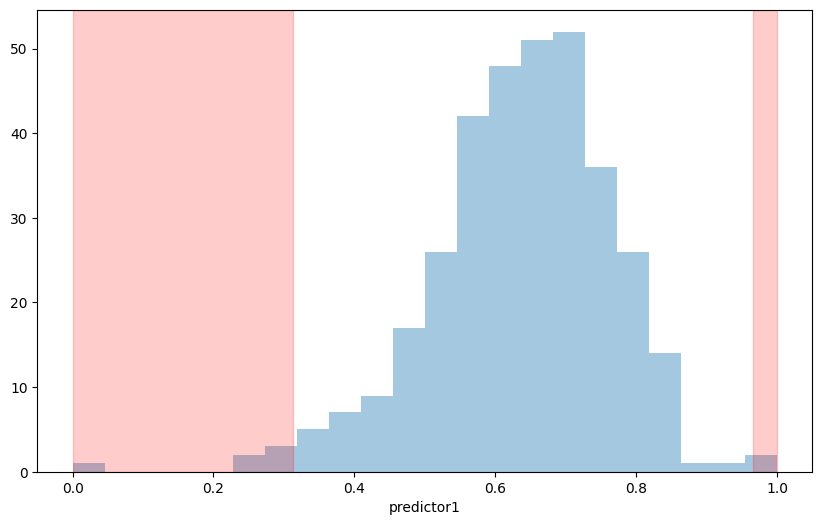

In [1153]:
plt.figure(figsize = (10,6))
sns.distplot(df_dummy.predictor1, kde=False)
plt.axvspan(xmin = lower,xmax= df_dummy.predictor1.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df_dummy.predictor1.max(),alpha=0.2, color='red')

In [1154]:
out_iqr(df_dummy,'predictor2')
#Input the dataset and the required column

The IQR is 0.2305389221556886
The lower bound value is 0.06437125748503003
The upper bound value is 0.9865269461077845
Total number of outliers are 4


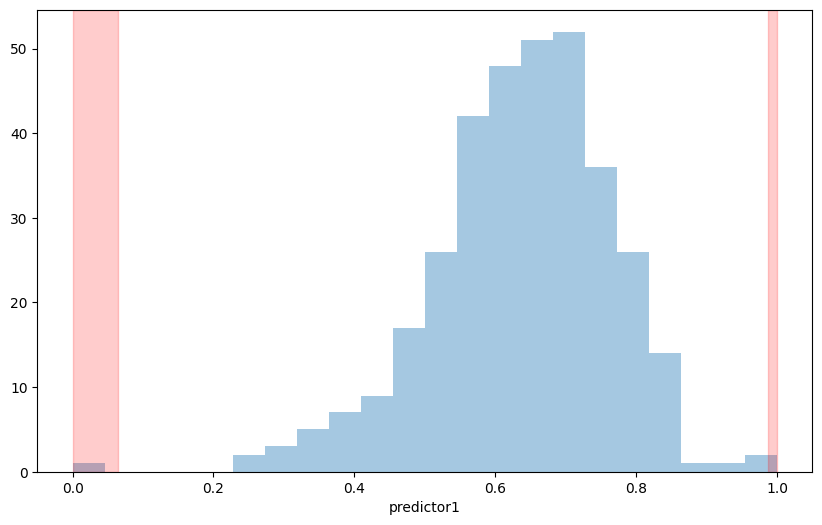

In [1155]:
plt.figure(figsize = (10,6))
sns.distplot(df_dummy.predictor1, kde=False)
plt.axvspan(xmin = lower,xmax= df_dummy.predictor2.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df_dummy.predictor2.max(),alpha=0.2, color='red')

In [1156]:
out_iqr(df_dummy,'predictor3')
#Input the dataset and the required column

The IQR is 0.16666666666666663
The lower bound value is 0.19
The upper bound value is 0.8566666666666665
Total number of outliers are 15


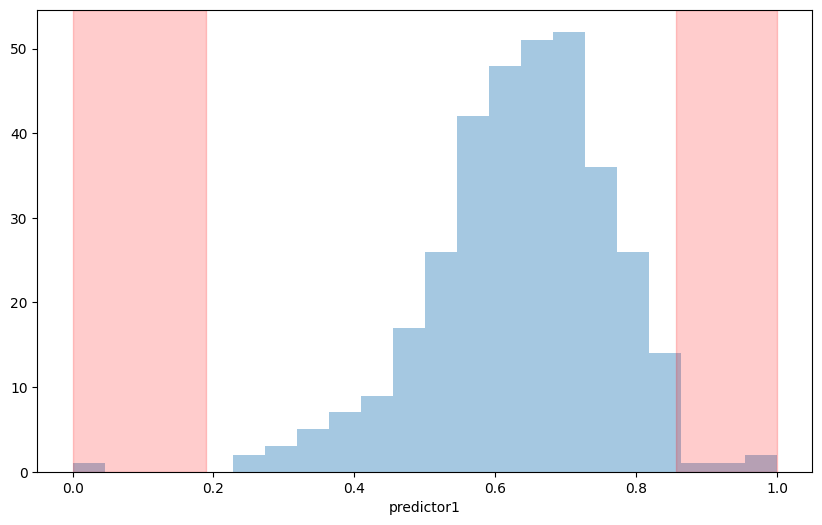

In [1157]:
plt.figure(figsize = (10,6))
sns.distplot(df_dummy.predictor1, kde=False)
plt.axvspan(xmin = lower,xmax= df_dummy.predictor3.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df_dummy.predictor3.max(),alpha=0.2, color='red')

In [1158]:
out_iqr(df_dummy,'predictor4')
#Input the dataset and the required column

The IQR is 0.22000000000000003
The lower bound value is 0.0033333333333332438
The upper bound value is 0.8833333333333334
Total number of outliers are 6


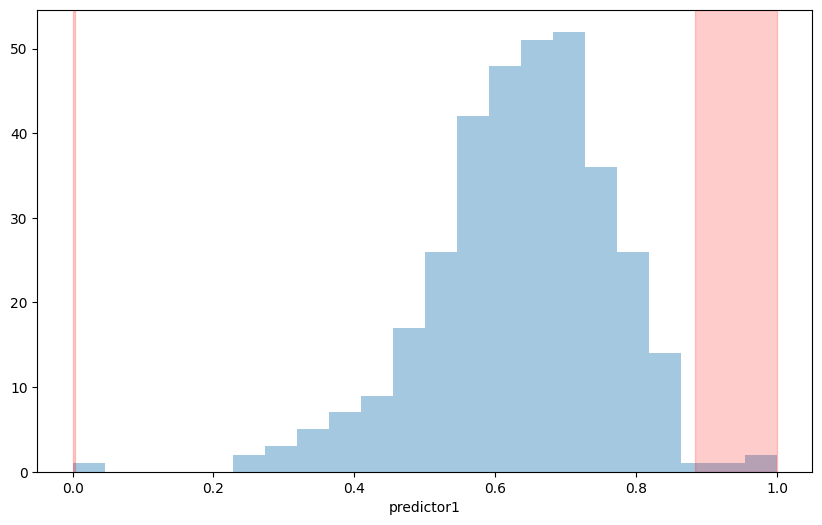

In [1159]:
plt.figure(figsize = (10,6))
sns.distplot(df_dummy.predictor1, kde=False)
plt.axvspan(xmin = lower,xmax= df_dummy.predictor4.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df_dummy.predictor4.max(),alpha=0.2, color='red')

## Remove the records which are above the upper bound value and records below the lower bound value!


In [1303]:

from scipy import stats

# Calculate Z-scores for each column
z_scores = np.abs(stats.zscore(df_dummy))

# Define a threshold for Z-score above which a data point is considered an outlier
z_threshold = 3

# Identify rows with outlier values
outliers = np.where(z_scores > z_threshold)



# Remove rows containing outliers
df_cleaned = df_dummy[(z_scores < z_threshold).all(axis=1)]

print("Original DataFrame:")
print(df_dummy)

print("\nCleaned DataFrame (outliers removed):")
print(df_cleaned)

Original DataFrame:
     predictor1  predictor2  predictor3  predictor4   ctar  individualperf  \
0      0.536842    1.000000    0.606667    0.606667  0.600        0.411392   
1      0.663158    0.820359    0.720000    0.606667  0.664        0.411392   
2      0.826316    0.742515    0.666667    0.440000  0.464        0.411392   
3      0.684211    0.658683    0.666667    0.666667  0.464        0.411392   
4      0.794737    0.580838    0.606667    0.666667  0.536        0.411392   
..          ...         ...         ...         ...    ...             ...   
341    0.526316    0.323353    0.500000    0.273333  1.000        0.284810   
342    0.657895    0.221557    0.440000    0.333333  0.736        0.221519   
343    0.363158    0.383234    0.440000    0.273333  0.600        0.221519   
344    0.547368    0.281437    0.273333    0.220000  0.136        0.221519   
345    0.257895    0.299401    0.440000    0.273333  0.400        0.221519   

          age    tenure  mbti_ENFJ  mbti_EN

## Train and Test Data ¶


In [1304]:
# Split the dataset into features and target
#X = df_cleaned[['predictor1','predictor2', 'predictor3', 'predictor4']]  # Features
#y = df_cleaned['individualperf']  # Target

X = df_cleaned.drop('individualperf', axis=1)
y = df_cleaned['individualperf']

In [1305]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)

(137, 27) (137,)
(60, 27) (60,)


In [1306]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
predictions = lin_reg.predict(X_test)

print("intercept: ", model.intercept_)
print("coef: ", model.coef_)
print("RScore. ", model.score(X_test,y_test))

intercept:  0.06058837419841667
coef:  [ 5.57790365e-02  3.74255056e-01  7.61448114e-03  3.79609336e-02
  1.18753577e-02  1.32448742e-02  8.00987615e-02 -6.50521303e-19
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.67464816e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.67464816e-03  0.00000000e+00 -7.52976223e-03
  7.52976223e-03 -9.37800285e-03  9.37800285e-03]
RScore.  0.4790312336299688


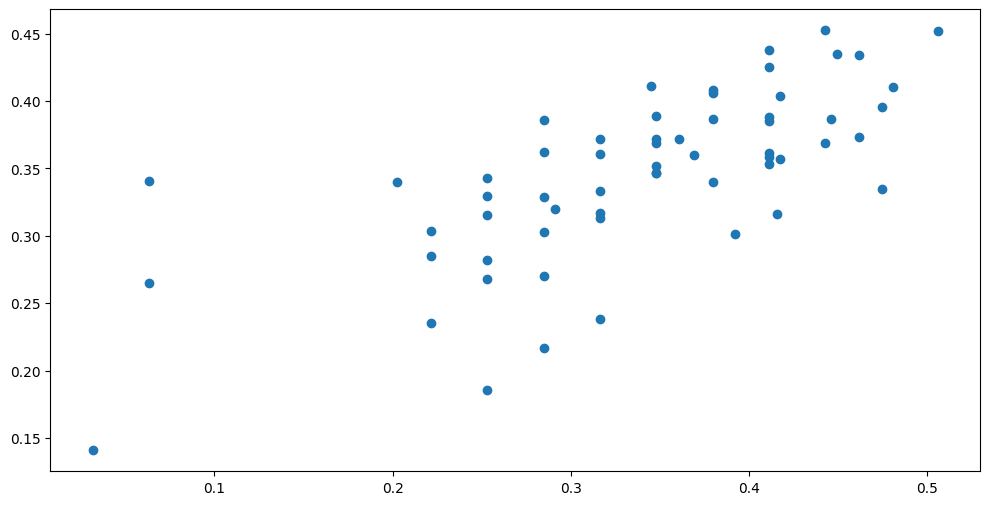

In [1307]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,predictions)
plt.show()

In [1308]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.053067098916245656
MSE: 0.005214808249309814
RMSE: 0.07221362924898467


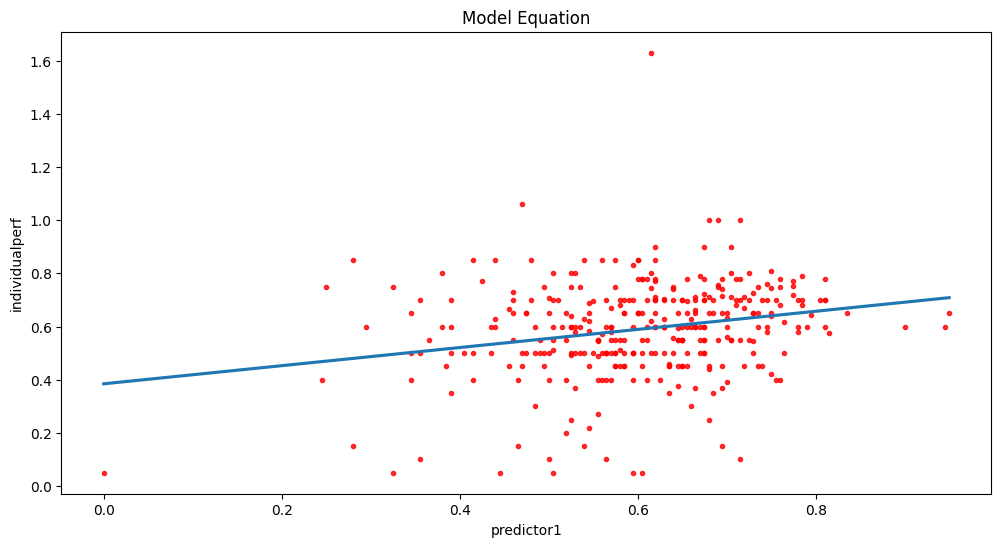

In [1309]:
plt.figure(figsize=(12,6))
g = sns.regplot(x=df['predictor1'],y=df["individualperf"],ci=None,scatter_kws = {'color':'r','s':9})
g.set_title("Model Equation")
g.set_ylabel("individualperf")
g.set_xlabel('predictor1')
plt.show()

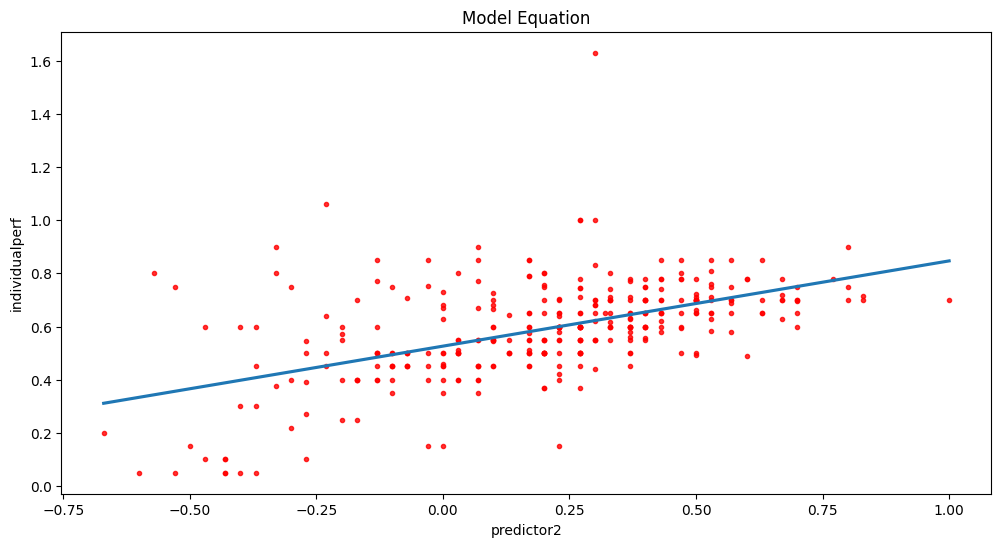

In [1310]:
plt.figure(figsize=(12,6))
g = sns.regplot(x=df['predictor2'],y=df["individualperf"],ci=None,scatter_kws = {'color':'r','s':9})
g.set_title("Model Equation")
g.set_ylabel("individualperf")
g.set_xlabel('predictor2')
plt.show()

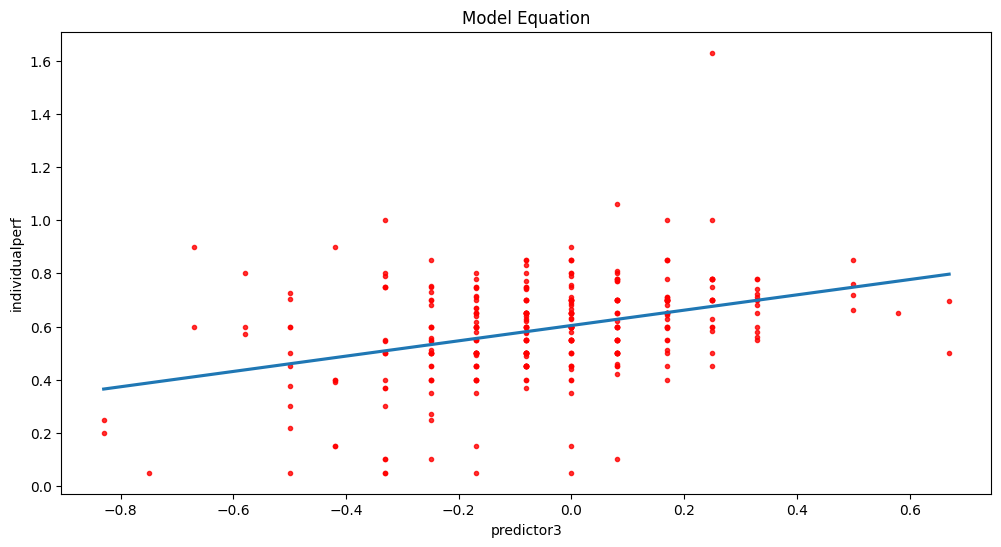

In [1311]:
plt.figure(figsize=(12,6))
g = sns.regplot(x=df['predictor3'],y=df["individualperf"],ci=None,scatter_kws = {'color':'r','s':9})
g.set_title("Model Equation")
g.set_ylabel("individualperf")
g.set_xlabel('predictor3')
plt.show()

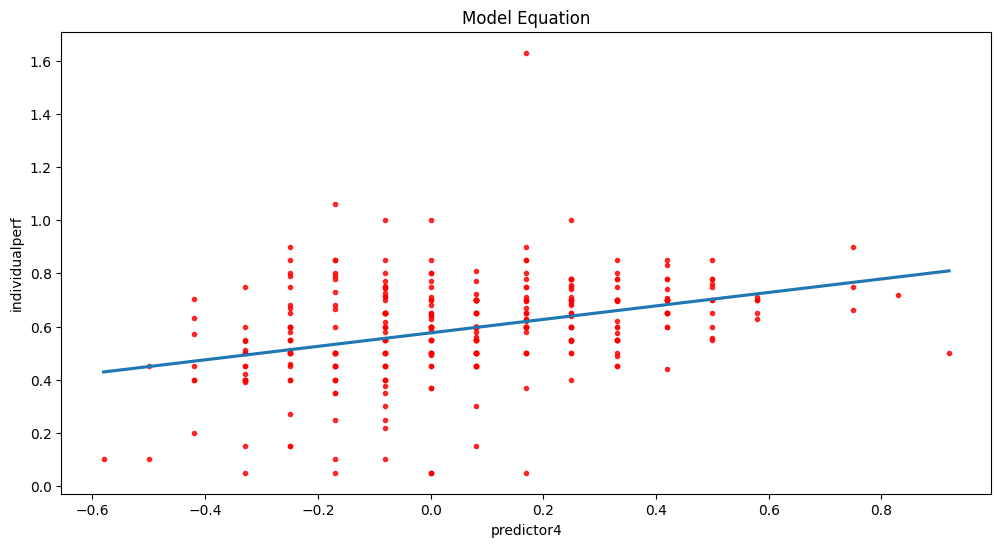

In [1312]:
plt.figure(figsize=(12,6))
g = sns.regplot(x=df['predictor4'],y=df["individualperf"],ci=None,scatter_kws = {'color':'r','s':9})
g.set_title("Model Equation")
g.set_ylabel("individualperf")
g.set_xlabel('predictor4')
plt.show()

In [1313]:
from sklearn.linear_model import LinearRegression

# Creating and training model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = lm.predict(X_test)


In [1314]:
ndf = [Reg_Models_Evaluation_Metrics(lm,X_train,y_train,X_test,y_test,y_pred)]

lm_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
lm_score.insert(0, 'Model', 'Linear Regression')
lm_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Linear Regression,0.479031,0.039464,0.343495,0.072214


Text(0.5, 1.0, 'Linear regression for RGB dataset')

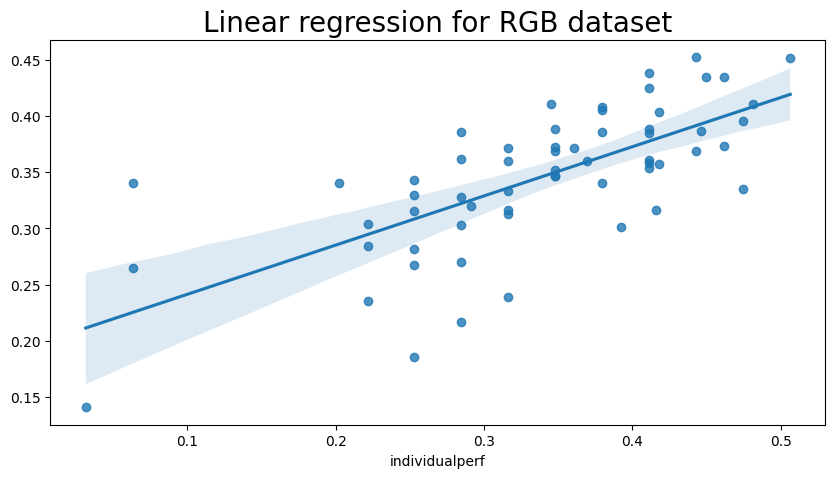

In [1315]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Linear regression for RGB dataset', fontsize = 20)


##  Random Forest

In [1316]:
from sklearn.ensemble import RandomForestRegressor

# Creating and training model
RandomForest_reg = RandomForestRegressor(n_estimators = 10, random_state = 0)

In [1317]:
RandomForest_reg.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = RandomForest_reg.predict(X_test)

In [1318]:
ndf = [Reg_Models_Evaluation_Metrics(RandomForest_reg,X_train,y_train,X_test,y_test,y_pred)]

rf_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rf_score.insert(0, 'Model', 'Random Forest')
rf_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Random Forest,0.446748,-0.020059,0.388414,0.074417


## Ridge Regression

In [1319]:
from sklearn.linear_model import Ridge

# Creating and training model
ridge_reg = Ridge(alpha=3, solver="cholesky")

In [1320]:
ridge_reg.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = ridge_reg.predict(X_test)


In [1321]:
ndf = [Reg_Models_Evaluation_Metrics(ridge_reg,X_train,y_train,X_test,y_test,y_pred)]

rr_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rr_score.insert(0, 'Model', 'Ridge Regression')
rr_score


,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Ridge Regression,0.406905,-0.09352,0.332093,0.077051


## XGBoost

In [1322]:
from xgboost import XGBRegressor
# create an xgboost regression model
XGBR = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.8, colsample_bytree=0.8)


In [1323]:
XGBR.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = XGBR.predict(X_test)


In [1324]:
ndf = [Reg_Models_Evaluation_Metrics(XGBR,X_train,y_train,X_test,y_test,y_pred)]

XGBR_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
XGBR_score.insert(0, 'Model', 'XGBoost')
XGBR_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,XGBoost,0.457745,0.000218,0.352574,0.073674


In [1325]:
predictions = pd.concat([rr_score, XGBR_score, lm_score,rf_score], ignore_index=True, sort=False)
predictions

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Ridge Regression,0.406905,-0.093520,0.332093,0.077051
1,XGBoost,0.457745,0.000218,0.352574,0.073674
2,Linear Regression,0.479031,0.039464,0.343495,0.072214
3,Random Forest,0.446748,-0.020059,0.388414,0.074417


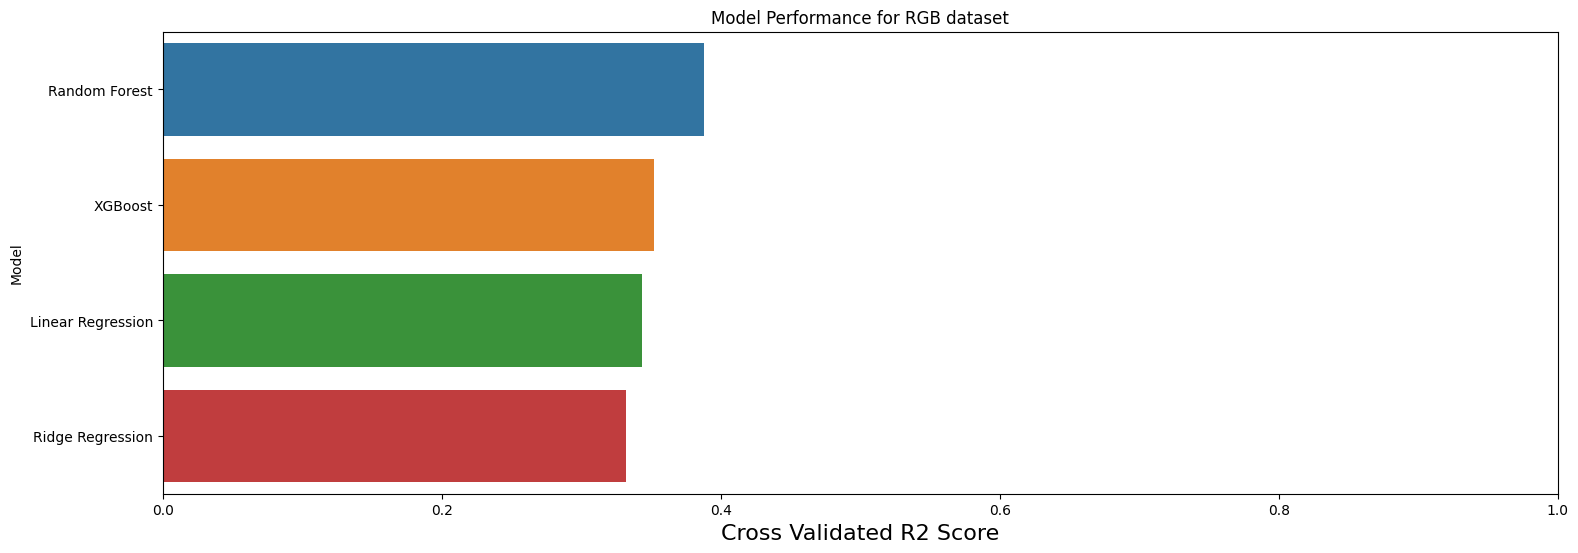

In [1326]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predictions.sort_values(by=['Cross Validated R2 Score'], ascending=False, inplace=True)

sns.barplot(x='Cross Validated R2 Score', y='Model', data = predictions, ax = axe)
axe.set_xlabel('Cross Validated R2 Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)

axe.set(title='Model Performance for RGB dataset')

plt.show()

## Feature scaling

In [1328]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features

    return df


In [1329]:
columns = ['id', 'company id', 'job', 'department', 'mbti', 'predictor1',
       'predictor2', 'predictor3', 'predictor4', 'ctar', 'aggregatetotpred',
       'decisionstd2', 'individualperf', 'gender', 'age', 'tenure', 'degree']

In [1330]:
df

,mbti,predictor1,predictor2,predictor3,predictor4,ctar,decisionstd2,individualperf,gender,age,tenure
0,ISTJ,0.510,1.00,0.08,0.33,0.00,Hired,0.7,F,35.0,12.0
1,ESTJ,0.630,0.70,0.25,0.33,0.08,Hired,0.7,M,42.0,16.0
2,ESTP,0.785,0.57,0.17,0.08,-0.17,Hired,0.7,M,40.0,12.0
3,ISTJ,0.650,0.43,0.17,0.42,-0.17,Hired,0.7,F,42.0,15.0
4,ISTJ,0.755,0.30,0.08,0.42,-0.08,Not Hired,0.7,M,37.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...
341,ISFJ,0.500,-0.13,-0.08,-0.17,0.50,Not Hired,0.5,F,30.0,3.0
342,ENTJ,0.625,-0.30,-0.17,-0.08,0.17,Not Hired,0.4,F,37.0,10.0
343,ISTJ,0.345,-0.03,-0.17,-0.17,0.00,Not Hired,0.4,M,31.0,13.0
344,ESTJ,0.520,-0.20,-0.42,-0.25,-0.58,Not Hired,0.4,F,27.0,2.0


In [1331]:
df_cleaned.columns

Index(['predictor1', 'predictor2', 'predictor3', 'predictor4', 'ctar',
       'individualperf', 'age', 'tenure', 'mbti_ENFJ', 'mbti_ENFP',
       'mbti_ENTJ', 'mbti_ENTP', 'mbti_ESFJ', 'mbti_ESFP', 'mbti_ESTJ',
       'mbti_ESTP', 'mbti_INFJ', 'mbti_INFP', 'mbti_INTJ', 'mbti_INTP',
       'mbti_ISFJ', 'mbti_ISFP', 'mbti_ISTJ', 'mbti_ISTP',
       'decisionstd2_Hired', 'decisionstd2_Not Hired', 'gender_F', 'gender_M'],
      dtype='object')

In [1332]:
df_cleaned.head()

,predictor1,predictor2,predictor3,predictor4,ctar,individualperf,age,tenure,mbti_ENFJ,mbti_ENFP,...,mbti_INTJ,mbti_INTP,mbti_ISFJ,mbti_ISFP,mbti_ISTJ,mbti_ISTP,decisionstd2_Hired,decisionstd2_Not Hired,gender_F,gender_M
0,0.536842,1.000000,0.606667,0.606667,0.600,0.411392,0.420144,0.413793,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.663158,0.820359,0.720000,0.606667,0.664,0.411392,0.603957,0.551724,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.684211,0.658683,0.666667,0.666667,0.464,0.411392,0.603957,0.517241,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.794737,0.580838,0.606667,0.666667,0.536,0.411392,0.472662,0.344828,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
7,0.363158,0.778443,0.666667,0.333333,0.864,0.379747,0.472662,0.172414,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [1333]:
col_names = ['predictor1', 'predictor2', 'predictor3', 'predictor4', 'ctar', 'age', 'mbti_ENFJ', 'mbti_ENFP',
       'mbti_ENTJ', 'mbti_ENTP', 'mbti_ESFJ', 'mbti_ESFP', 'mbti_ESTJ',
       'mbti_ESTP', 'mbti_INFJ', 'mbti_INFP', 'mbti_INTJ', 'mbti_INTP',
       'mbti_ISFJ', 'mbti_ISFP', 'mbti_ISTJ', 'mbti_ISTP',
       'decisionstd2_Hired', 'decisionstd2_Not Hired', 'gender_F', 'gender_M']

X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)



In [1334]:
X_train

,predictor1,predictor2,predictor3,predictor4,ctar,age,tenure,mbti_ENFJ,mbti_ENFP,mbti_ENTJ,...,mbti_INTJ,mbti_INTP,mbti_ISFJ,mbti_ISFP,mbti_ISTJ,mbti_ISTP,decisionstd2_Hired,decisionstd2_Not Hired,gender_F,gender_M
274,1.267486,-1.310225,-0.549051,-1.478625,0.079066,0.184612,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.022143,0.0,-0.472456,0.472456,-1.022143,1.022143
57,2.796492,-0.367689,0.668889,0.155982,-1.719140,2.233955,0.620690,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.022143,0.0,-0.472456,0.472456,-1.022143,1.022143
45,0.440996,-0.716776,0.279148,0.514798,0.079066,1.283060,0.181034,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.022143,0.0,-0.472456,0.472456,-1.022143,1.022143
163,-0.550792,-0.961138,-0.110592,-0.481914,0.421582,-0.498502,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.978337,0.0,-0.472456,0.472456,0.978337,-0.978337
261,0.358347,0.574848,-0.549051,-0.481914,0.079066,0.047990,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.978337,0.0,-0.472456,0.472456,0.978337,-0.978337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,1.060863,-0.961138,-0.110592,0.155982,-0.991295,0.047990,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.022143,0.0,-0.472456,0.472456,0.978337,-0.978337
21,-0.840064,0.225760,-0.110592,0.155982,-0.306264,0.731104,0.482759,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.022143,0.0,-0.472456,0.472456,0.978337,-0.978337
157,-0.922713,-0.367689,1.107347,-0.840730,-1.719140,-1.454861,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.978337,0.0,-0.472456,0.472456,0.978337,-0.978337
306,-2.699666,-0.123327,1.107347,-0.162966,0.764097,-1.454861,0.068966,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.022143,0.0,-0.472456,0.472456,0.978337,-0.978337


## Comparing different models

## Linear Regression


In [1335]:
from sklearn.linear_model import LinearRegression

# Creating and training model
lm = LinearRegression()
lm.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = lm.predict(X_test)

In [1336]:
ndf = [Reg_Models_Evaluation_Metrics(lm,X_train,y_train,X_test,y_test,y_pred)]

lm_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
lm_score.insert(0, 'Model', 'Linear Regression')
lm_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Linear Regression,0.494338,0.067686,0.343495,0.071145


Text(0.5, 1.0, 'Linear regression for RGB dataset')

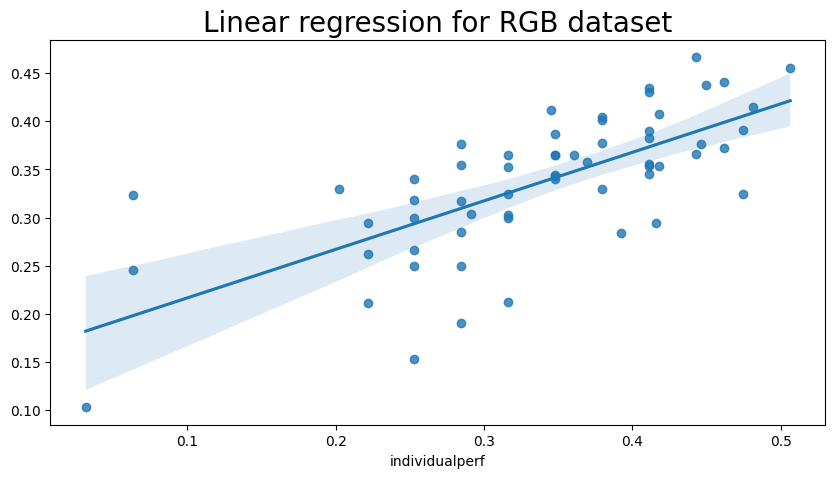

In [1337]:
plt.figure(figsize = (10,5))
sns.regplot(x=y_test,y=y_pred)
plt.title('Linear regression for RGB dataset', fontsize = 20)

## Random Forrest

In [1338]:
from sklearn.ensemble import RandomForestRegressor

# Creating and training model
RandomForest_reg = RandomForestRegressor(n_estimators = 10, random_state = 0)

In [1339]:
RandomForest_reg.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = RandomForest_reg.predict(X_test)

In [1340]:
ndf = [Reg_Models_Evaluation_Metrics(RandomForest_reg,X_train,y_train,X_test,y_test,y_pred)]

rf_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rf_score.insert(0, 'Model', 'Random Forest')
rf_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Random Forest,0.465667,0.014824,0.391266,0.073134


## Ridge Regression

In [1341]:
from sklearn.linear_model import Ridge

# Creating and training model
ridge_reg = Ridge(alpha=3, solver="cholesky")

In [1342]:
ridge_reg.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = ridge_reg.predict(X_test)

In [1343]:
ndf = [Reg_Models_Evaluation_Metrics(ridge_reg,X_train,y_train,X_test,y_test,y_pred)]

rr_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rr_score.insert(0, 'Model', 'Ridge Regression')
rr_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Ridge Regression,0.498061,0.074551,0.35356,0.070882


## XGBoost

In [1344]:
from xgboost import XGBRegressor
# create an xgboost regression model
XGBR = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.8, colsample_bytree=0.8)

In [1345]:
XGBR.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = XGBR.predict(X_test)


In [1346]:
ndf = [Reg_Models_Evaluation_Metrics(XGBR,X_train,y_train,X_test,y_test,y_pred)]

XGBR_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
XGBR_score.insert(0, 'Model', 'XGBoost')
XGBR_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,XGBoost,0.418995,-0.071227,0.35307,0.076261


## Recursive Feature Elimination (RFE)

In [1347]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# create pipeline
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=60)
model = RandomForestRegressor()
rf_pipeline = Pipeline(steps=[('s',rfe),('m',model)])


In [1348]:
rf_pipeline.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = rf_pipeline.predict(X_test)

In [1349]:
ndf = [Reg_Models_Evaluation_Metrics(rf_pipeline,X_train,y_train,X_test,y_test,y_pred)]

rfe_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
rfe_score.insert(0, 'Model', 'Random Forest with RFE')
rfe_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Random Forest with RFE,0.494417,0.067832,0.411674,0.071139


##  Final Model Evaluation

In [1350]:
predictions = pd.concat([rfe_score, XGBR_score, rr_score, rf_score, lm_score], ignore_index=True, sort=False)
predictions

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Random Forest with RFE,0.494417,0.067832,0.411674,0.071139
1,XGBoost,0.418995,-0.071227,0.353070,0.076261
2,Ridge Regression,0.498061,0.074551,0.353560,0.070882
3,Random Forest,0.465667,0.014824,0.391266,0.073134
4,Linear Regression,0.494338,0.067686,0.343495,0.071145


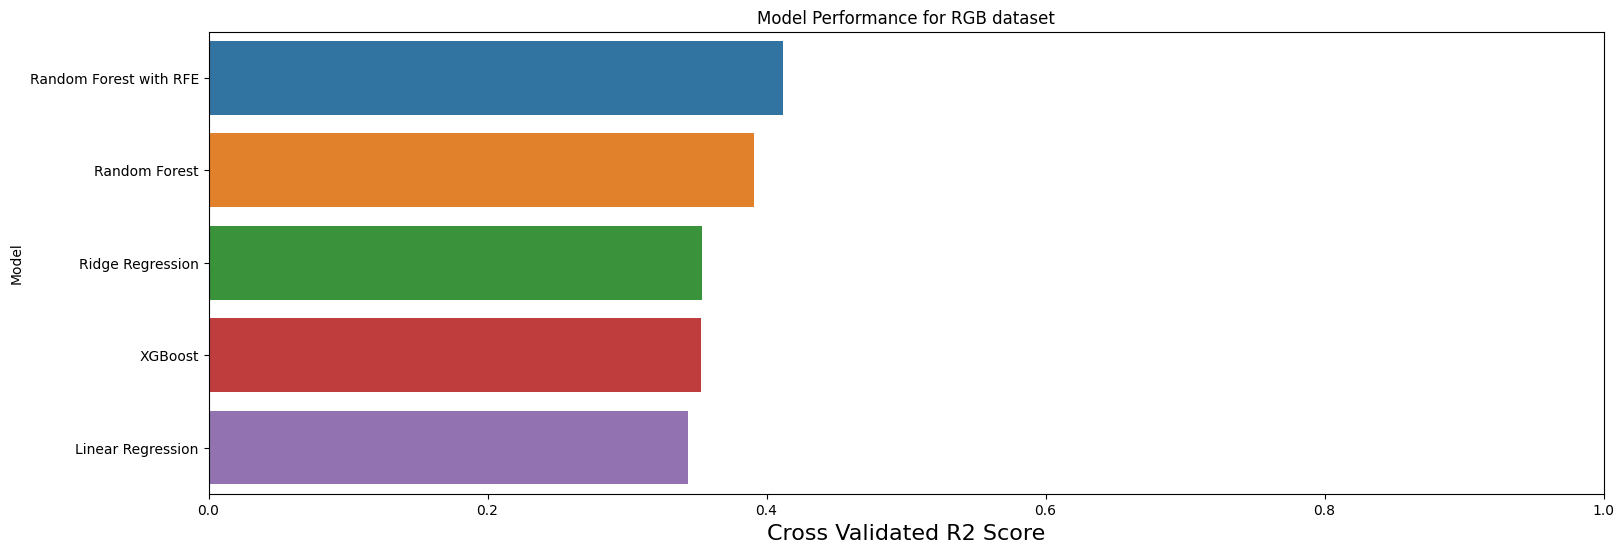

In [1351]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predictions.sort_values(by=['Cross Validated R2 Score'], ascending=False, inplace=True)

sns.barplot(x='Cross Validated R2 Score', y='Model', data = predictions, ax = axe)
axe.set_xlabel('Cross Validated R2 Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)

axe.set(title='Model Performance for RGB dataset')

plt.show()

## Hyperparameter Tuning Using GridSearchCV

Tuned Ridge Regression

In [1352]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial features are those features created by raising existing features to an exponent.
# For example, if a dataset had one input feature X,
# then a polynomial feature would be the addition of a new feature (column) where values were calculated by squaring the values in X, e.g. X^2.

steps = [
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=3.8, fit_intercept=True))
]

ridge_pipe = Pipeline(steps)
ridge_pipe.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = ridge_pipe.predict(X_test)


In [1353]:
from sklearn.model_selection import GridSearchCV

alpha_params = [{'model__alpha': list(range(1, 15))}]

clf = GridSearchCV(ridge_pipe, alpha_params, cv = 10)

In [1354]:
# Fit and tune model
clf.fit(X_train, y_train)
# Model making a prediction on test data
y_pred = ridge_pipe.predict(X_test)
# The combination of hyperparameters along with values that give the best performance of our estimate specified
print(clf.best_params_)


{'model__alpha': 14}


In [1355]:
ndf = [Reg_Models_Evaluation_Metrics(clf,X_train,y_train,X_test,y_test,y_pred)]

clf_score = pd.DataFrame(data = ndf, columns=['R2 Score','Adjusted R2 Score','Cross Validated R2 Score','RMSE'])
clf_score.insert(0, 'Model', 'Tuned Ridge Regression')
clf_score

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Tuned Ridge Regression,0.231488,-0.416943,0.150383,0.096135


## Final performance comparison

In [1356]:
result = pd.concat([clf_score, predictions], ignore_index=True, sort=False)
result

,Model,R2 Score,Adjusted R2 Score,Cross Validated R2 Score,RMSE
0,Tuned Ridge Regression,0.231488,-0.416943,0.150383,0.096135
1,Random Forest with RFE,0.494417,0.067832,0.411674,0.071139
2,Random Forest,0.465667,0.014824,0.391266,0.073134
3,Ridge Regression,0.498061,0.074551,0.353560,0.070882
4,XGBoost,0.418995,-0.071227,0.353070,0.076261
5,Linear Regression,0.494338,0.067686,0.343495,0.071145


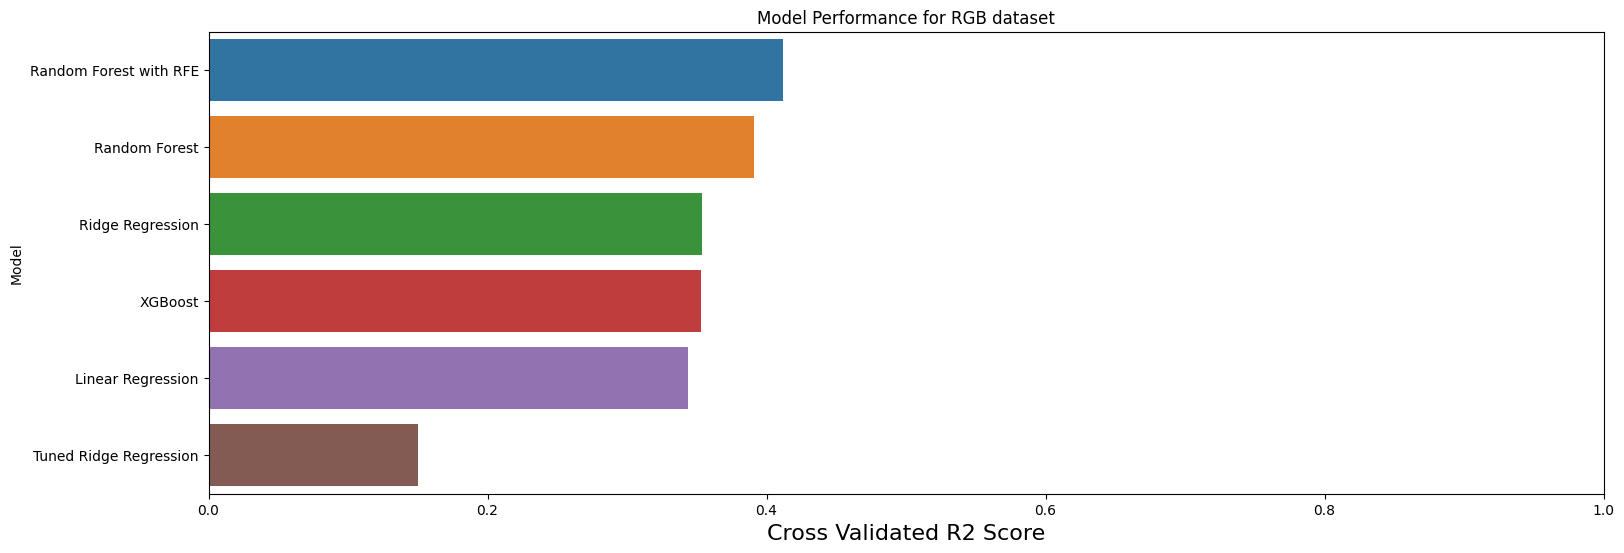

In [1357]:
f, axe = plt.subplots(1,1, figsize=(18,6))

result.sort_values(by=['Cross Validated R2 Score'], ascending=False, inplace=True)

sns.barplot(x='Cross Validated R2 Score', y='Model', data = result, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross Validated R2 Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
axe.set(title='Model Performance for RGB dataset')

plt.show()